# Initial experimentation with negative-binomial models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1104
np.random.seed(RANDOM_SEED)

## Example: School absences

The following is from a tutorial in negative binomial regression from UCLA's IDRE: https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/

### Load the data

In [5]:
school_data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")
school_data["id"] = pd.Categorical(school_data["id"].astype(int))

program_cat = {1: "General", 2: "Academic", 3: "Vocational"}
school_data["prog"] = school_data["prog"].astype(int).map(program_cat)
school_data["prog"] = pd.Categorical(
    school_data["prog"], categories=program_cat.values(), ordered=True
)

school_data.head()

,id,gender,math,daysabs,prog
0,1001,male,63.0,4.0,Academic
1,1002,male,27.0,4.0,Academic
2,1003,female,20.0,2.0,Academic
3,1004,female,16.0,3.0,Academic
4,1005,female,2.0,3.0,Academic


### Data viz 

Explore the data, particularly the `daysabs` column.

In [6]:
school_data.describe()

,math,daysabs
count,314.000000,314.000000
mean,48.267517,5.955414
std,25.362392,7.036958
min,1.000000,0.000000
25%,28.000000,1.000000
50%,48.000000,4.000000
75%,70.000000,8.000000
max,99.000000,35.000000


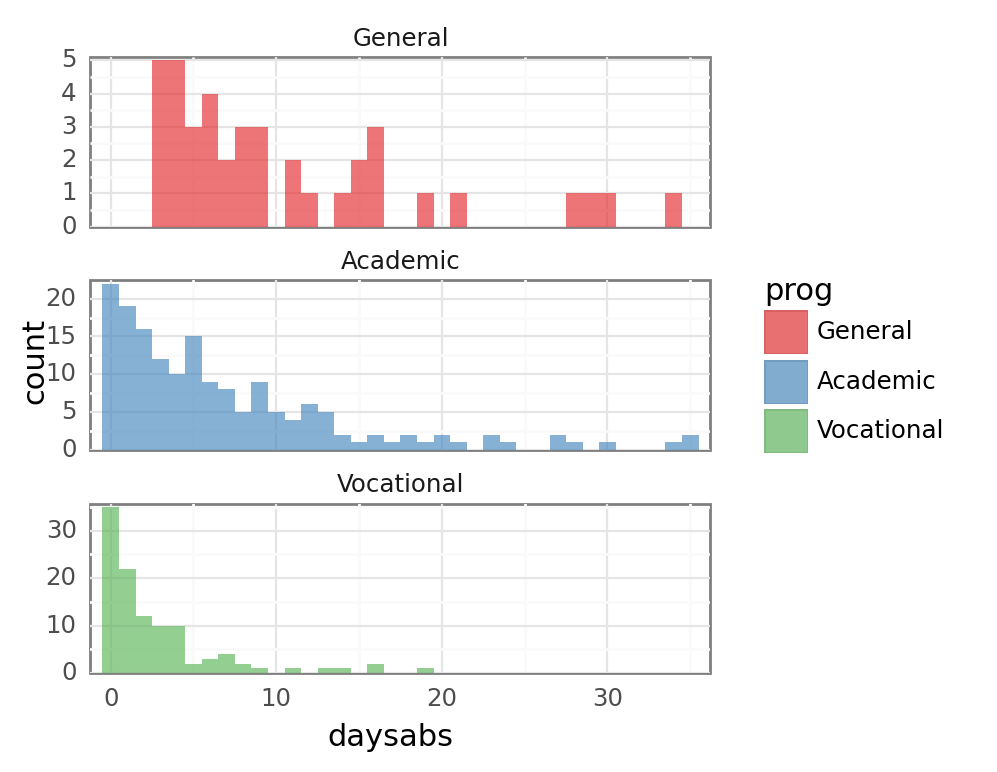

<ggplot: (347717322)>

In [7]:
(
    gg.ggplot(school_data, gg.aes(x="daysabs"))
    + gg.facet_wrap("prog", ncol=1, scales="free_y")
    + gg.geom_histogram(gg.aes(fill="prog"), binwidth=1, alpha=0.6)
    + gg.scale_x_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Set1")
)

In [8]:
school_data.groupby("prog").agg({"daysabs": ["mean", "std"]}).round(2)

daysabs      
              mean   std
prog                    
General      10.65  8.20
Academic      6.93  7.45
Vocational    2.67  3.73

### Negative binomial regression

#### Using the GLM module in PyMC3

In [9]:
def process_school_data_for_modeling(df: pd.DataFrame) -> dict[str, np.ndarray]:
    return {
        "x_math": df.math.values,
        "x_prog": pd.get_dummies(df.prog).values,
        "y_daysabs": df.daysabs.values,
    }

In [10]:
model_data = process_school_data_for_modeling(school_data)

In [11]:
with pm.Model() as nb:
    x_math_shared = pm.Data("x_math_shared", model_data["x_math"])
    x_prog_shared = pm.Data("x_prog_shared", model_data["x_prog"])
    y_daysabs_shared = pm.Data("y_daysabs_shared", model_data["y_daysabs"])

    β_math = pm.Normal("β_math", 0, 5)
    β_prog = pm.Normal("β_prog", 0, 5, shape=3)
    η = pm.Deterministic(
        "η", pm.math.dot(x_prog_shared, β_prog) + β_math * x_math_shared
    )
    μ = tt.exp(η)
    α = pm.HalfNormal("α", 5)
    daysabs = pm.NegativeBinomial("daysabs", μ, α, observed=y_daysabs_shared)

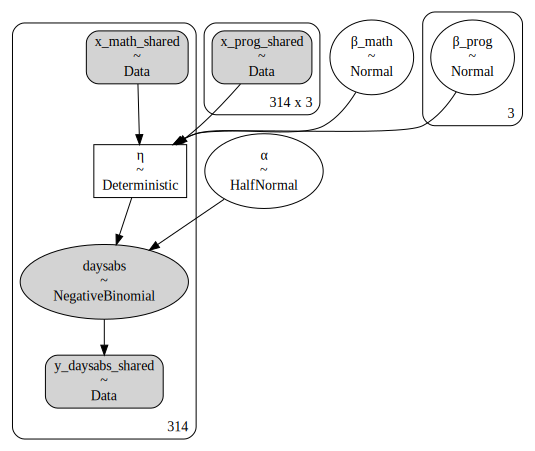

In [12]:
pm.model_to_graphviz(nb)

In [13]:
with nb:
    nb_trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=2,
        random_seed=123,
        return_inferencedata=True,
    )
    ppc = pm.sample_posterior_predictive(nb_trace)
    nb_trace.add_groups({"posterior_predictive": ppc})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β_prog, β_math]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


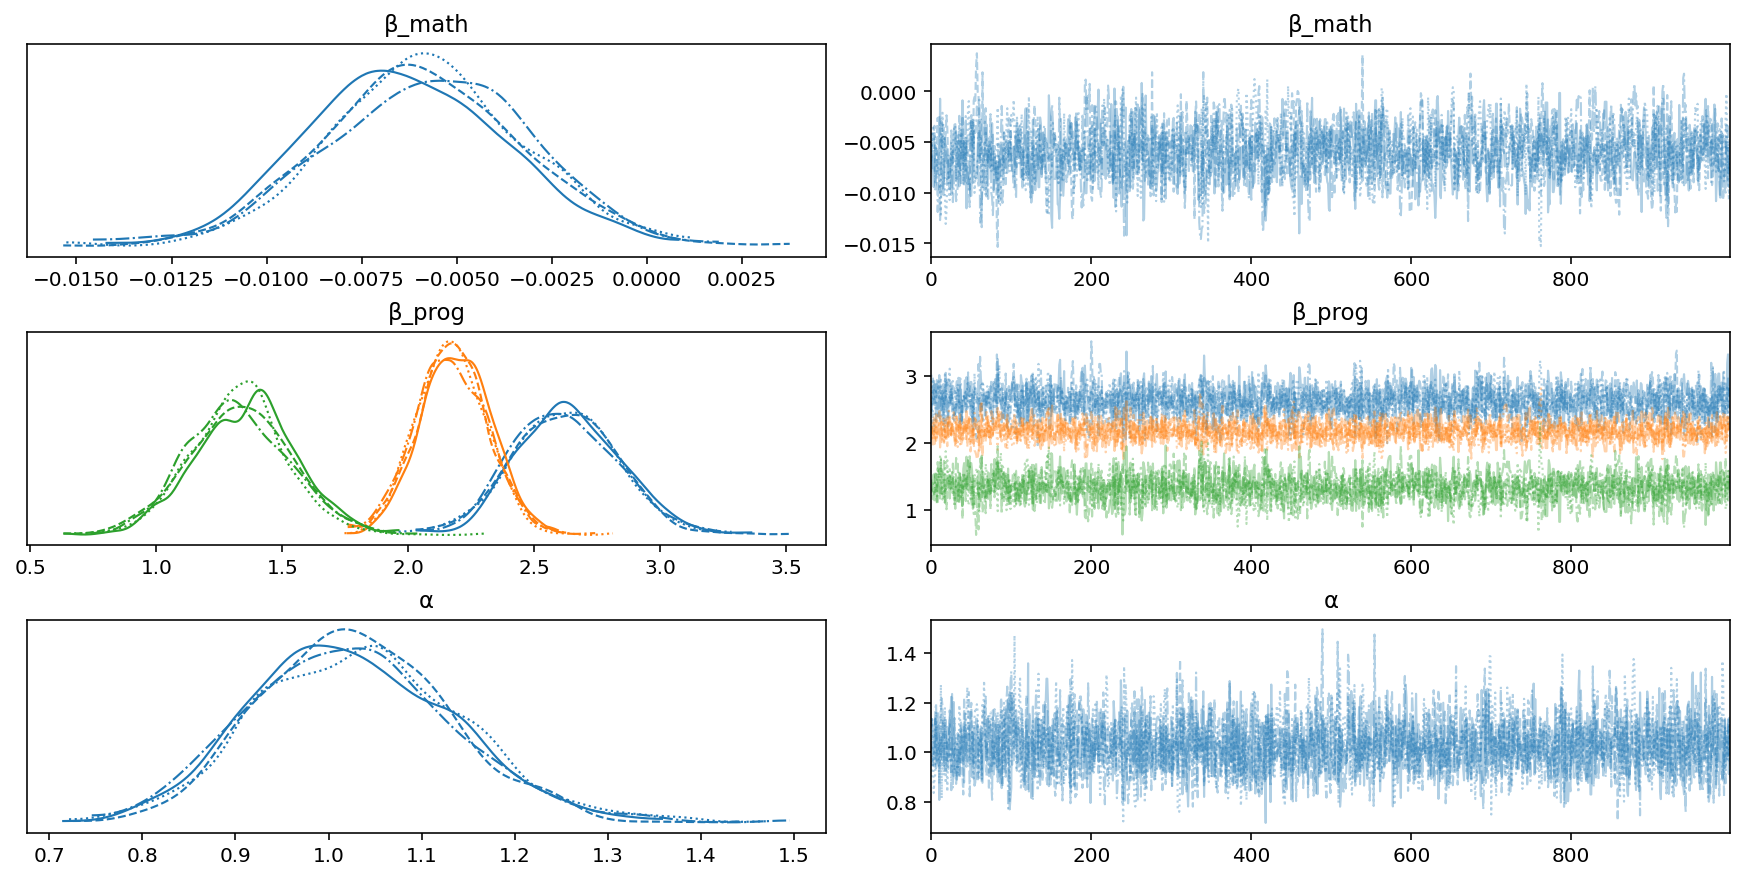

In [14]:
main_vars = ["β_math", "β_prog", "α"]
az.plot_trace(nb_trace, var_names=main_vars);

In [15]:
az.summary(nb_trace, var_names=main_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_math,-0.006,0.003,-0.011,-0.001,0.000,0.000,1500.0,1933.0,1.01
β_prog[0],2.626,0.206,2.253,3.014,0.004,0.003,2115.0,2190.0,1.00
β_prog[1],2.177,0.139,1.918,2.435,0.003,0.002,1859.0,2088.0,1.00
β_prog[2],1.336,0.199,0.970,1.717,0.005,0.003,1830.0,1948.0,1.00
α,1.028,0.107,0.829,1.226,0.002,0.001,3262.0,2851.0,1.00


Below are the results from the IDRE example using the following model.

```r
m1 <- glm.nb(daysabs ~ math + prog, data = dat)
summary(m1)
```

```
## Call:
## glm.nb(formula = daysabs ~ math + prog, data = dat, init.theta = 1.032713156, 
##     link = log)
## 
## Deviance Residuals: 
##    Min      1Q  Median      3Q     Max  
## -2.155  -1.019  -0.369   0.229   2.527  
## 
## Coefficients:
##                Estimate Std. Error z value Pr(>|z|)    
## (Intercept)     2.61527    0.19746   13.24  < 2e-16 ***
## math           -0.00599    0.00251   -2.39    0.017 *  
## progAcademic   -0.44076    0.18261   -2.41    0.016 *  
## progVocational -1.27865    0.20072   -6.37  1.9e-10 ***
## ---
## Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
## 
## (Dispersion parameter for Negative Binomial(1.033) family taken to be 1)
## 
##     Null deviance: 427.54  on 313  degrees of freedom
## Residual deviance: 358.52  on 310  degrees of freedom
## AIC: 1741
## 
## Number of Fisher Scoring iterations: 1
## 
## 
##               Theta:  1.033 
##           Std. Err.:  0.106 
## 
##  2 x log-likelihood:  -1731.258
```

All of the MAP values in my NB model are the same as the point estimates in their model.
In their example, the other categories for `prog` are separate values *in addition* to the intercept, but in my model, there are three varying intercepts. 
In other words, to get the effect for `prog = Academic`, in the IDRE model add `progAcademic + (Intercept)`, but in my NB model, it is just `β_prog[1]`.

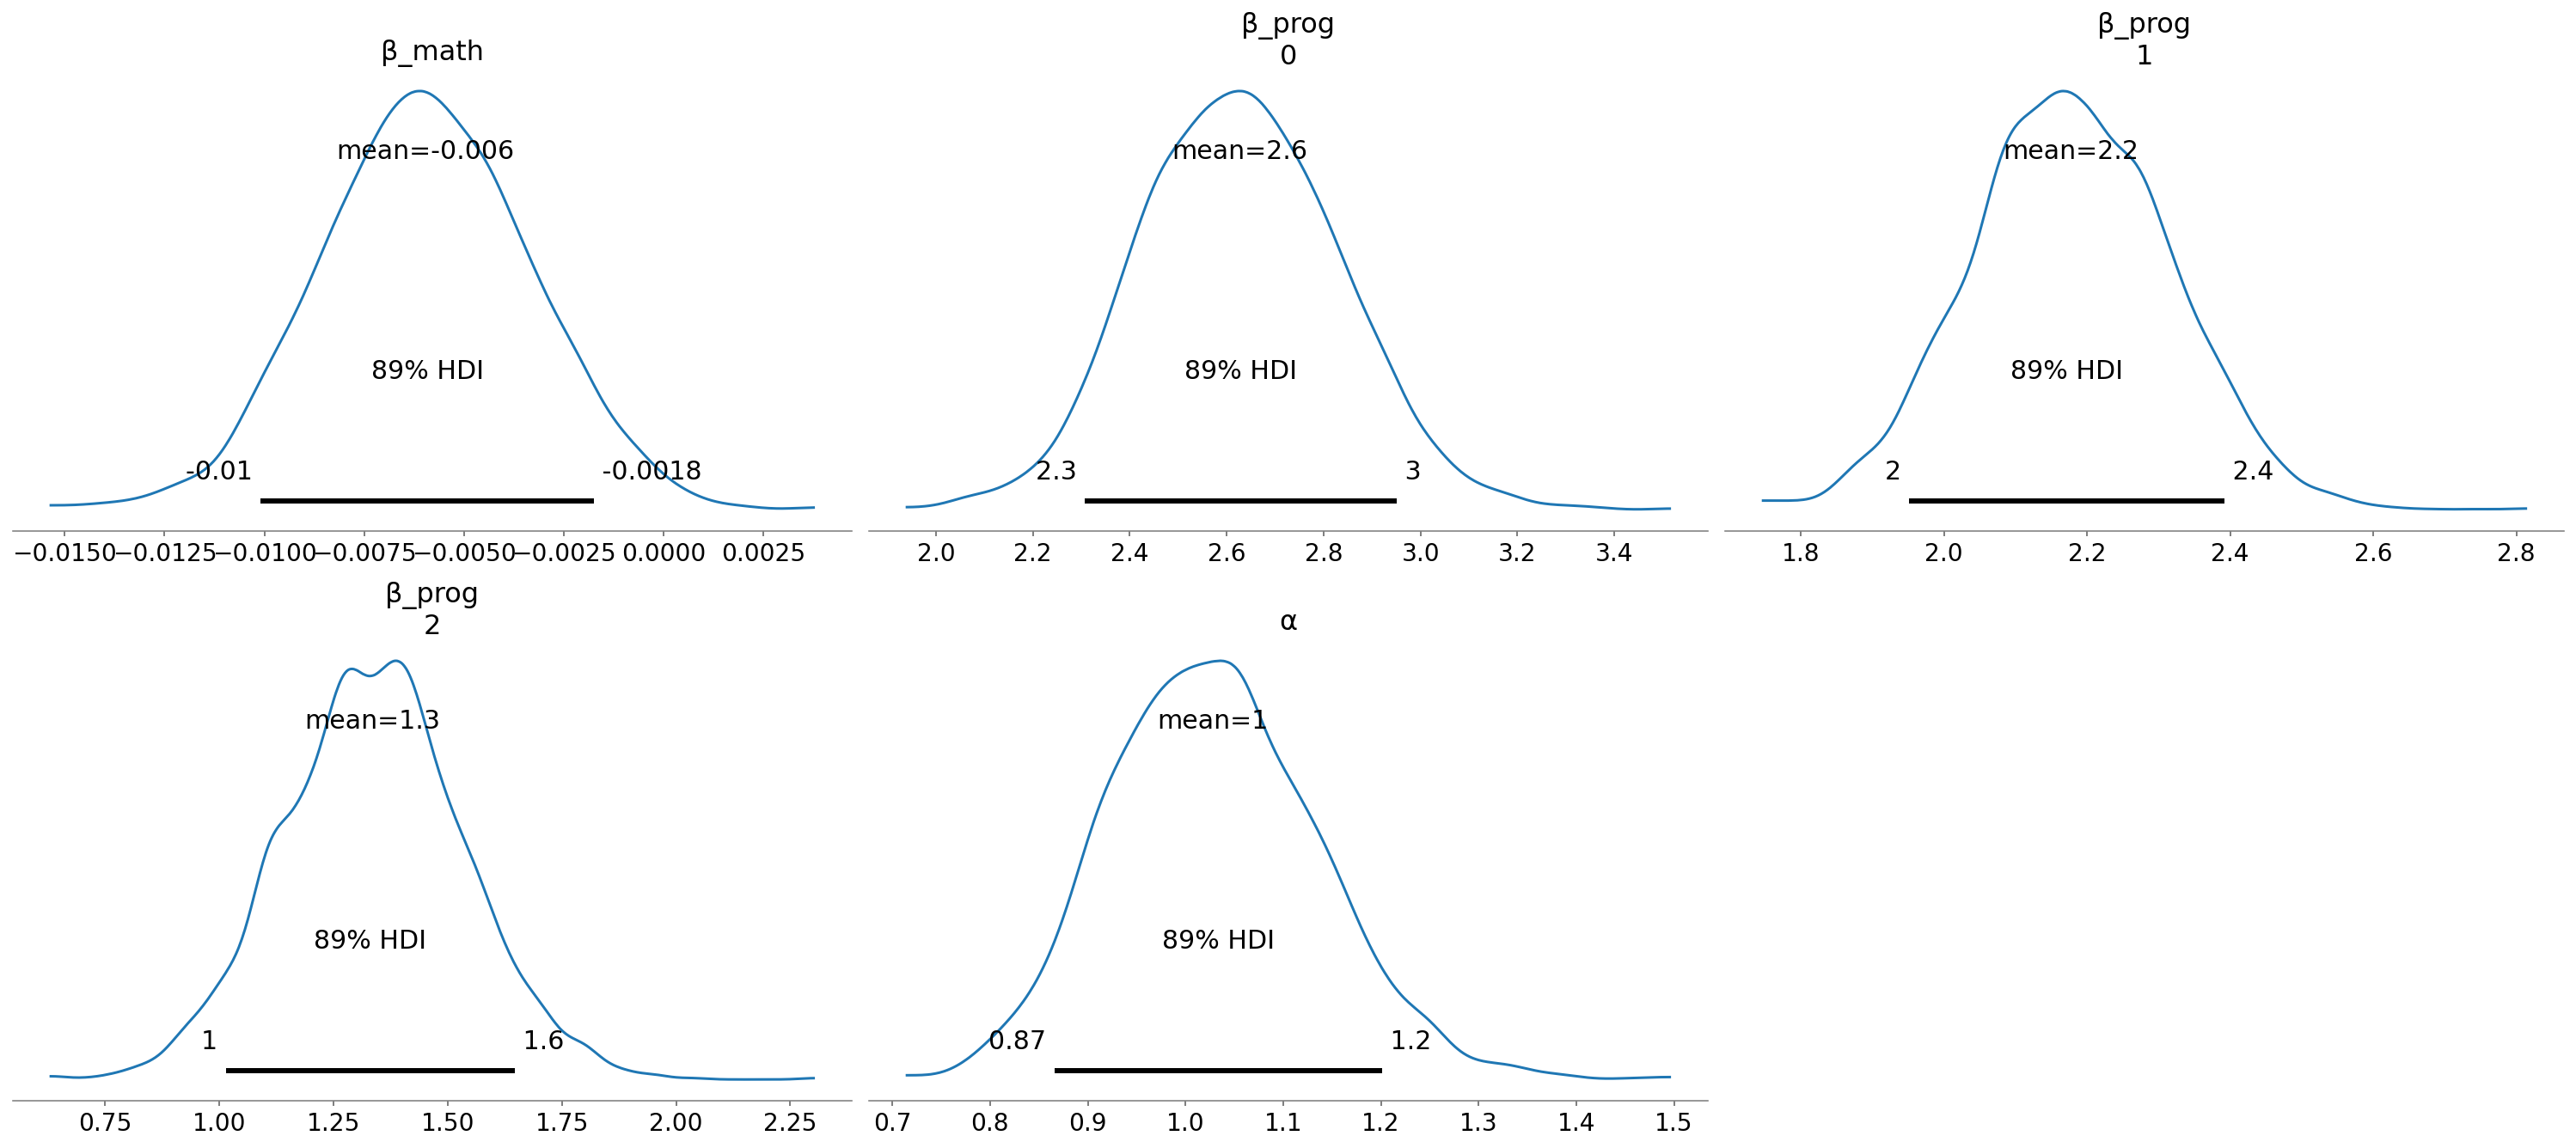

In [16]:
az.plot_posterior(nb_trace, var_names=main_vars, hdi_prob=0.89);

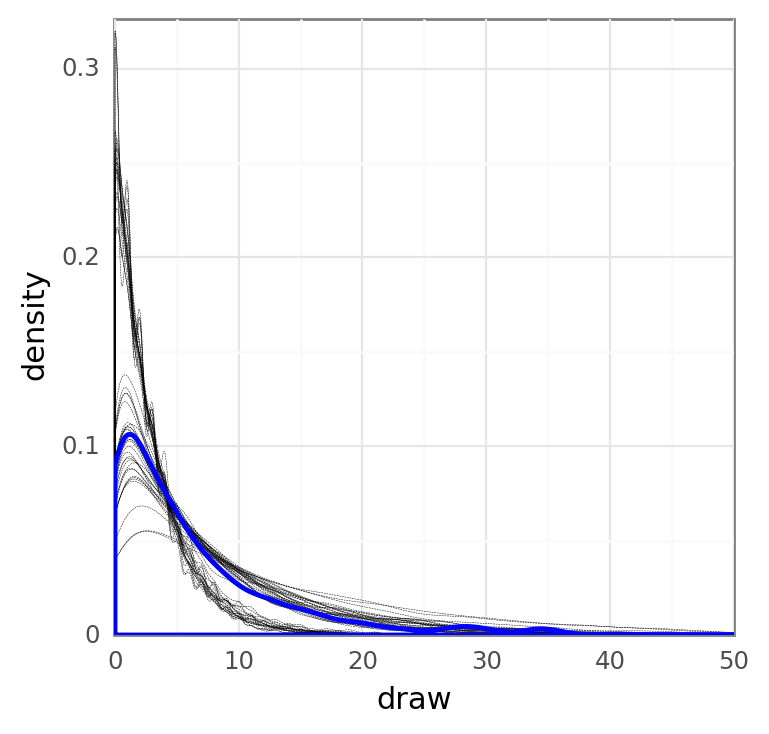

<ggplot: (352068039)>

In [17]:
r_idx = np.arange(ppc["daysabs"].shape[1])
np.random.shuffle(r_idx)
ppc_df = pd.DataFrame(ppc["daysabs"][:, r_idx[:50]]).pivot_longer(
    names_to="ppc_idx", values_to="draw"
)

(
    gg.ggplot(ppc_df, gg.aes(x="draw"))
    + gg.geom_density(gg.aes(group="ppc_idx"), linetype="--", size=0.1)
    + gg.geom_density(gg.aes(x="daysabs"), data=school_data, color="b", size=1)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_x_continuous(limits=(0, 50), expand=(0, 0.1, 0, 0))
)

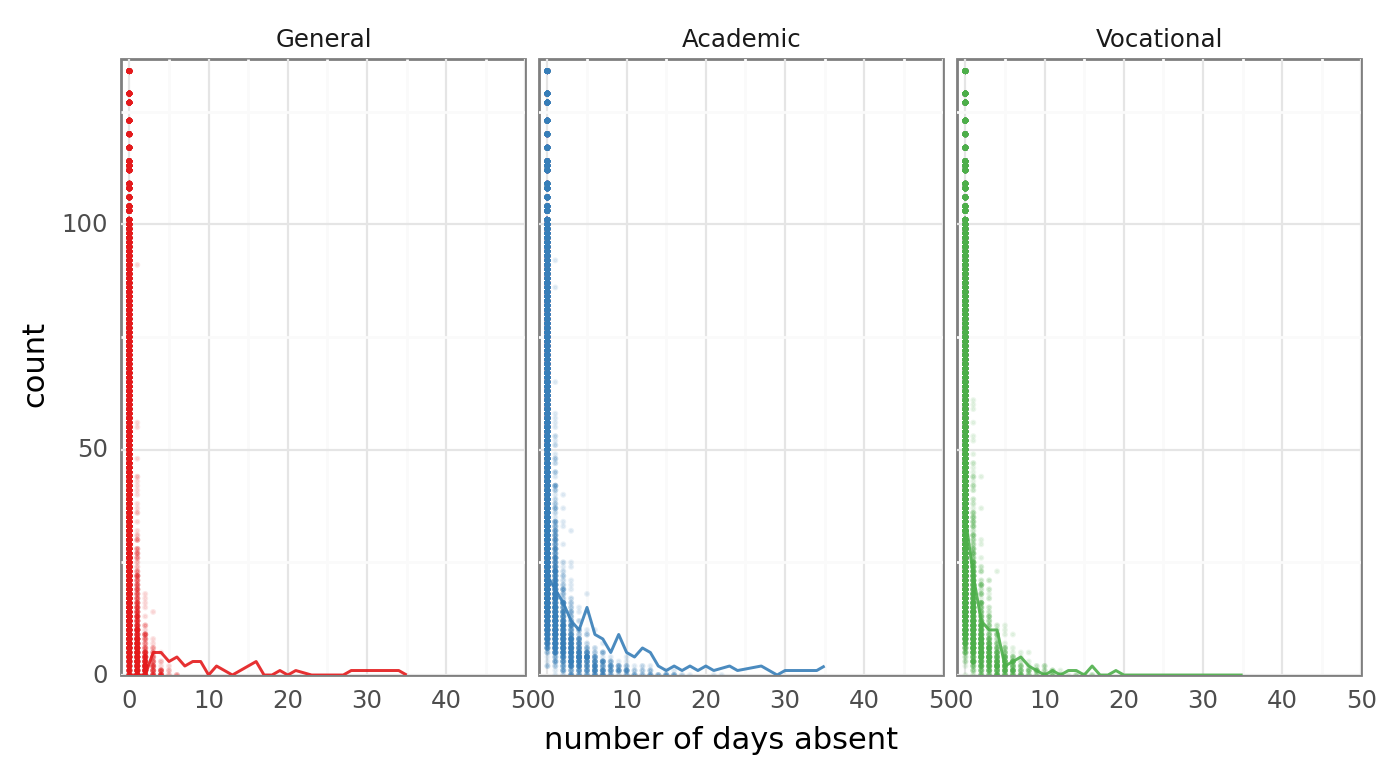

<ggplot: (350159222)>

In [18]:
num_samples = 100
ppc_counts_df = (
    pd.DataFrame(ppc["daysabs"][:, r_idx[:num_samples]])
    .assign(prog=school_data.prog[r_idx[:num_samples]])
    .pivot_longer(index="prog", names_to="ppc_idx", values_to="draw")
    .assign(x=0)
    .groupby(["prog", "ppc_idx", "draw"])
    .count()
    .reset_index(drop=False)
)

real_counts = school_data.groupby(["prog", "daysabs"]).count().reset_index(drop=False)

(
    gg.ggplot(ppc_counts_df)
    + gg.facet_grid(". ~ prog")
    + gg.geom_point(gg.aes(x="x", y="draw", color="prog"), size=0.2, alpha=0.1)
    + gg.geom_line(
        gg.aes(x="daysabs", color="prog", y="id"),
        data=real_counts,
        size=0.6,
        alpha=0.9,
    )
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_x_continuous(limits=(0, 50), expand=(0.02, 0, 0, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(8, 4), legend_position="none")
    + gg.labs(x="number of days absent", y="count")
)

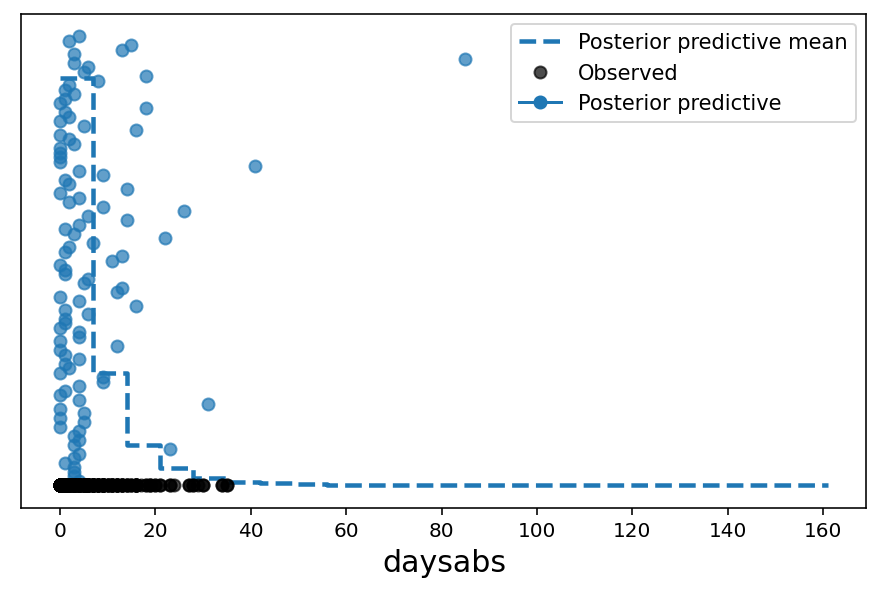

In [19]:
az.plot_ppc(nb_trace, num_pp_samples=100, kind="scatter");

I next want to replicate their plot shown below.
It is showing the effect of the math score on number of days absent for each program.

![idre-nb-regression-plot](assets/nbreg-unnamed-chunk-11.png)

In [20]:
math_scores = np.arange(school_data.math.min(), school_data.math.max(), step=0.1)
newdata = pd.DataFrame(
    {
        "prog": np.repeat(list(program_cat.values()), len(math_scores)),
        "math": np.tile(math_scores, len(program_cat)),
        "daysabs": 0,
    }
)
newdata["prog"] = pd.Categorical(
    newdata["prog"], categories=program_cat.values(), ordered=True
)

newdata.head()

,prog,math,daysabs
0,General,1.0,0
1,General,1.1,0
2,General,1.2,0
3,General,1.3,0
4,General,1.4,0


In [21]:
newdata_processed = process_school_data_for_modeling(newdata)
with nb:
    pm.set_data(
        {
            "x_math_shared": newdata_processed["x_math"],
            "x_prog_shared": newdata_processed["x_prog"],
        }
    )
    daysabs_post_pred = pm.sample_posterior_predictive(nb_trace, var_names=["daysabs"])
    eta_post_pred = pm.sample_posterior_predictive(nb_trace, var_names=["η"])

In [22]:
post_pred_df = (
    pmanal.summarize_posterior_predictions(
        daysabs_post_pred["daysabs"], merge_with=newdata, observed_y="daysabs"
    )
    .drop("daysabs", axis=1)
    .rename(
        columns={
            "pred_mean": "pred_daysabs_mean",
            "pred_hdi_low": "pred_daysabs_low",
            "pred_hdi_high": "pred_daysabs_high",
        }
    )
)

eta_post_pred = pmanal.summarize_posterior_predictions(eta_post_pred["η"]).rename(
    columns={
        "pred_mean": "pred_eta_mean",
        "pred_hdi_low": "pred_eta_low",
        "pred_hdi_high": "pred_eta_high",
    }
)

post_pred_df = pd.concat([post_pred_df, eta_post_pred], axis=1)
post_pred_df.head()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_daysabs_mean,pred_daysabs_low,pred_daysabs_high,prog,math,pred_eta_mean,pred_eta_low,pred_eta_high
0,14.28900,0.0,33.0,General,1.0,2.620382,2.302848,2.941070
1,13.73075,0.0,31.0,General,1.1,2.619785,2.302827,2.940389
2,13.77475,0.0,31.0,General,1.2,2.619189,2.302663,2.939673
3,14.25225,0.0,31.0,General,1.3,2.618592,2.302421,2.938974
4,14.43925,0.0,32.0,General,1.4,2.617996,2.301756,2.937968


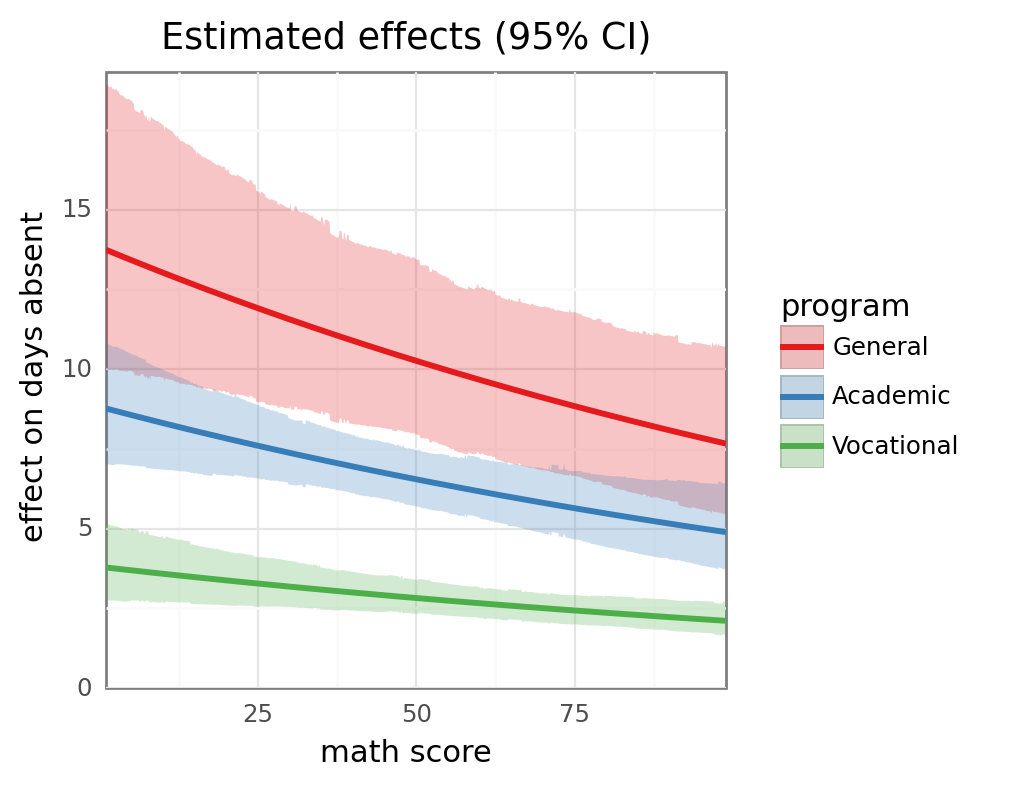

<ggplot: (352241369)>

In [23]:
(
    gg.ggplot(post_pred_df, gg.aes(x="math"))
    + gg.geom_ribbon(
        gg.aes(ymin="np.exp(pred_eta_low)", ymax="np.exp(pred_eta_high)", fill="prog"),
        alpha=0.25,
    )
    + gg.geom_line(gg.aes(y="np.exp(pred_eta_mean)", color="prog"), size=1.2)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(limits=(0, None), expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="math score",
        y="effect on days absent",
        fill="program",
        color="program",
        title="Estimated effects (95% CI)",
    )
)

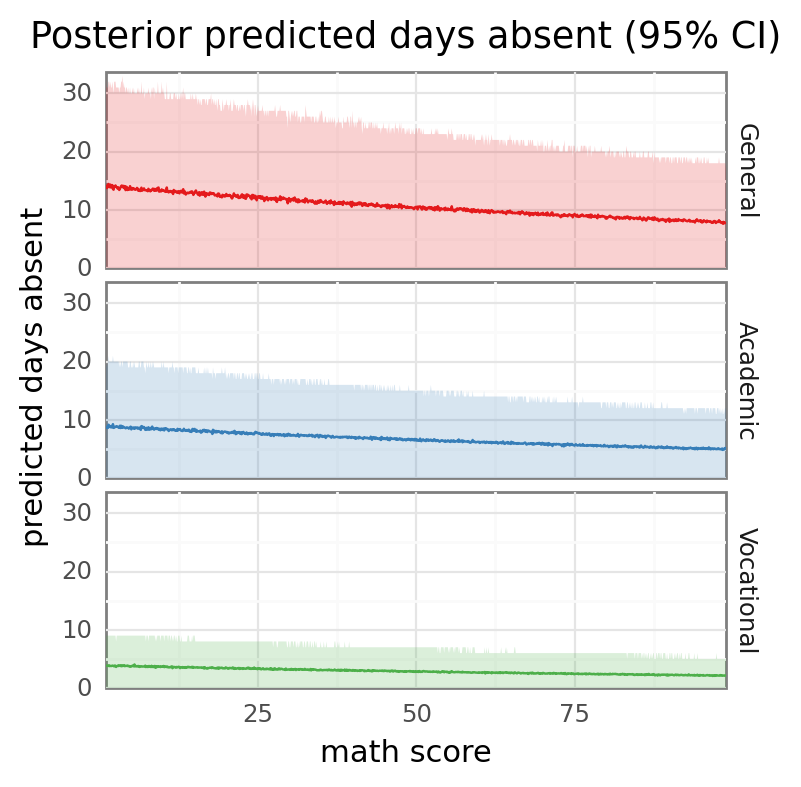

<ggplot: (352045614)>

In [24]:
(
    gg.ggplot(post_pred_df, gg.aes(x="math"))
    + gg.facet_grid("prog ~")
    + gg.geom_ribbon(
        gg.aes(ymin="pred_daysabs_low", ymax="pred_daysabs_high", fill="prog"),
        alpha=0.2,
    )
    + gg.geom_line(gg.aes(y="pred_daysabs_mean", color="prog"))
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(limits=(0, None), expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position="none")
    + gg.labs(
        x="math score",
        y="predicted days absent",
        fill="program",
        color="program",
        title="Posterior predicted days absent (95% CI)",
    )
)

---

In [25]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.41 minutes


In [26]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-09-08

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: nb-model

janitor   : 0.21.0
re        : 2.2.1
arviz     : 0.11.2
theano    : 1.0.5
plotnine  : 0.8.0
numpy     : 1.21.2
matplotlib: 3.4.3
pymc3     : 3.11.2
pandas    : 1.3.2
seaborn   : 0.11.2

